# Reliable Fully Local RAG Agents using LangGraph With Map Reduce And Parallelization
This notebook demonstrates how **parallelization** enhances the performance of Retrieval-Augmented Generation (RAG) agents by executing tasks concurrently.

## **What Is Parallelization?**

Parallelization refers to the process of splitting a computational task into smaller sub-tasks, allowing them to be processed simultaneously. This approach reduces execution time and increases the efficiency of handling large-scale computations.

In the context of this notebook, parallelization is used to execute two independent nodes concurrently, speeding up the overall process.

## **How It Improves RAG Agents**

By leveraging parallelization, this notebook enables:
- **Parallel Task Execution**: Tasks such as grading answers and hallucination evaluation are processed simultaneously, improving overall speed.
- **Faster Decision Making**: The agent can perform both evaluations in parallel, speeding up the process of generating or retrieving answers.

## **Key Benefits**

Using parallelization improves the RAG agent in the following ways:
- **Increased Speed**: By executing multiple tasks at the same time, the agent can deliver results faster.
- **Improved Efficiency**: Reduces processing time, enabling quicker decision-making.
- **Simplified Workflow**: Parallel execution of tasks allows for simultaneous operations without additional complexity.

In [1]:
import json
import logging
import operator
import os
from typing import Annotated, List

import chromadb
import httpx
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.schema import Document
from langchain_chroma import Chroma
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.constants import Send
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict

load_dotenv(dotenv_path="../../.env.research")

False

In [2]:
client = chromadb.HttpClient(
    host=os.getenv("CHROMA_HOST"), port=int(os.getenv("CHROMA_PORT"))
)

In [3]:
### LLM
local_llm = str(os.getenv("LLM_MODEL"))
llm = ChatOllama(model=local_llm, temperature=0.1)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")
embedder = OllamaEmbeddings(
    model=str(os.getenv("EMBEDDING_MODEL")), base_url=os.getenv("OLLAMA_URI")
)

In [4]:
def load_pdfs_from_directory(directory_path):
    all_documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(directory_path, filename)
            loader = PDFPlumberLoader(file_path=file_path)
            documents = loader.load()
            all_documents.extend(documents)
    return all_documents

In [5]:
if os.getenv("CHROMA_COLLECTION_NAME") not in [
    collection.name for collection in client.list_collections()
]:
    pdf_docs = load_pdfs_from_directory(os.getenv("DATA_DIR"))
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_documents(pdf_docs)
    vectorstore = None
    try:
        vectorstore = Chroma(
            client=client,
            collection_name=os.getenv("CHROMA_COLLECTION_NAME"),
            embedding_function=OllamaEmbeddings(
                model="nomic-embed-text", base_url=os.getenv("OLLAMA_URI")
            ),
        )
        vectorstore.add_documents(documents=all_splits)
    except httpx.ConnectError as e:
        logging.error(f"Could not connect to Chroma: {e}")
        vectorstore.delete_collection()

In [6]:
### Retriever
vectorstore = Chroma(
    collection_name=os.getenv("CHROMA_COLLECTION_NAME"),
    client=client,
    embedding_function=embedder,
    create_collection_if_not_exists=False,
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

## Components

In [7]:
### Router

# Prompt
router_instructions = """You are a routing assistant that determines the best data source to answer user questions. There are three options:

Vectorstore: Use this for **specific and detailed questions** about the rules, setup, or gameplay of Rummikub.
Websearch: Use this for **recent changes to Rummikub rules**, **current events**, or information explicitly marked as being **outside the scope** of the vectorstore.
Irrelevant: Use this for **questions unrelated to Rummikub**, including general questions about unrelated topics, technologies, or concepts or uncertain questions.

**Output Format:**
Respond strictly in the following JSON format:

{"datasource": "<vectorstore | websearch | irrelevant>"}

**Guidelines:**
1. Use `vectorstore` **only** for questions directly referencing Rummikub rules, setup, or gameplay. Examples:
   - "What are the rules for forming sets in Rummikub?"
   - "How many tiles does each player start with?"
2. Use `websearch` **only** for questions requiring external research or recent updates about Rummikub. Examples:
   - "Who is the current world champion of Rummikub?"
   - "Have there been recent changes to Rummikub rules?"
3. Use `irrelevant` for all other questions, including general knowledge or unrelated topics. Examples:
   - "What are the main causes of global warming?"
   - "What are the types of agent memory?"

Always prioritize the most accurate category.
"""

In [8]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

In [9]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:

{context}

Carefully analyze the context above.

Now, review the user question:

{question}

Provide a clear, direct, and concise answer to the user's question, using only the information from the context. Avoid repeating long excerpts from the context verbatim unless necessary to clarify your response.

Make sure the answer is well-structured, easy to understand, and directly addresses the user's query.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [10]:
### Hallucination Grader


# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz.

You will be given FACTS and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS.

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
"""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}.

Return JSON with one key, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS."""

In [11]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
"""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.

Return JSON with one key, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria."""

In [12]:
web_search_tool = TavilySearchResults(max_results=3)

In [23]:
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents
    filtered_docs: Annotated[
        list[str], operator.add
    ]  # Filtered out irrelevant documents
    grades: Annotated[list[str], operator.add]  # Grade of document relevance
    generation_grades: Annotated[
        list[str], operator.add
    ]  # Grade of generation relevance
    decision: str  # Decision to use generation

In [24]:
### Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}


def handle_irrelevant(state):
    """
    Handle irrelevant questions

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains response to irrelevant question
    """
    print("---HANDLE IRRELEVANT---")
    return {
        "generation": "This question is not related to the Rummikub rules. Please ask something specific about the game."
    }


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["filtered_docs"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def continue_to_gradings(state):
    return [
        Send("grade_document", {"document": d, "question": state["question"]})
        for d in state["documents"]
    ]


def grade_document(state):
    question = state["question"]
    doc = state["document"]
    doc_grader_prompt_formatted = doc_grader_prompt.format(
        document=doc.page_content, question=question
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=doc_grader_instructions)]
        + [HumanMessage(content=doc_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]
    if grade.lower() == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        return {"filtered_docs": [doc], "grades": [grade]}
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        return {"grades": [grade]}


def grade_docs(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    print("---CHECK IF WEB SEARCH IS NECESSARY---")
    grades = state["grades"]
    web_search = "Yes" if all(x.lower() == "no" for x in grades) else "No"
    return {"web_search": web_search}


def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}


### Edges


def route_question(state):
    """
    Route question to web search or RAG or none

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source == "irrelevant":
        print("---ROUTE QUESTION TO IRRELEVANT---")
        return "irrelevant"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_hallucination(state):
    """
    Determines whether the generation is grounded in the document

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---GRADE HALLUCINATION---")
    documents = state["filtered_docs"]
    generation = state["generation"]
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]
    if grade.lower() == "yes":
        print("---DECISION: GENERATION GROUNDED IN DOCUMENT---")
        return {"generation_grades": [grade]}
    return {"generation_grades": ["hallucinated"]}


def grade_answer(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---GRADE GENERATION vs QUESTION---")
    question = state["question"]
    generation = state["generation"]
    answer_grader_prompt_formatted = answer_grader_prompt.format(
        question=question, generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=answer_grader_instructions)]
        + [HumanMessage(content=answer_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]
    if grade.lower() == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return {"generation_grades": [grade]}
    return {"generation_grades": ["not grounded"]}


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK GRADINGS---")
    gradings = state["generation_grades"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided
    loop_step = state.get("loop_step", 0)
    if all(x.lower() == "yes" for x in gradings):
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        decision = "useful"
    elif "not grounded" in gradings:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        decision = "not useful"
    elif "hallucinated" in gradings:
        print("---DECISION: GENERATION HALLUCINATED---")
        decision = "not supported"
    elif loop_step >= max_retries:
        print("---DECISION: MAX RETRIES REACHED---")
        decision = "max retries"
    else:
        print("---DECISION: GENERATION NOT GRADED---")
        decision = "generate"
    return {"decision": decision}

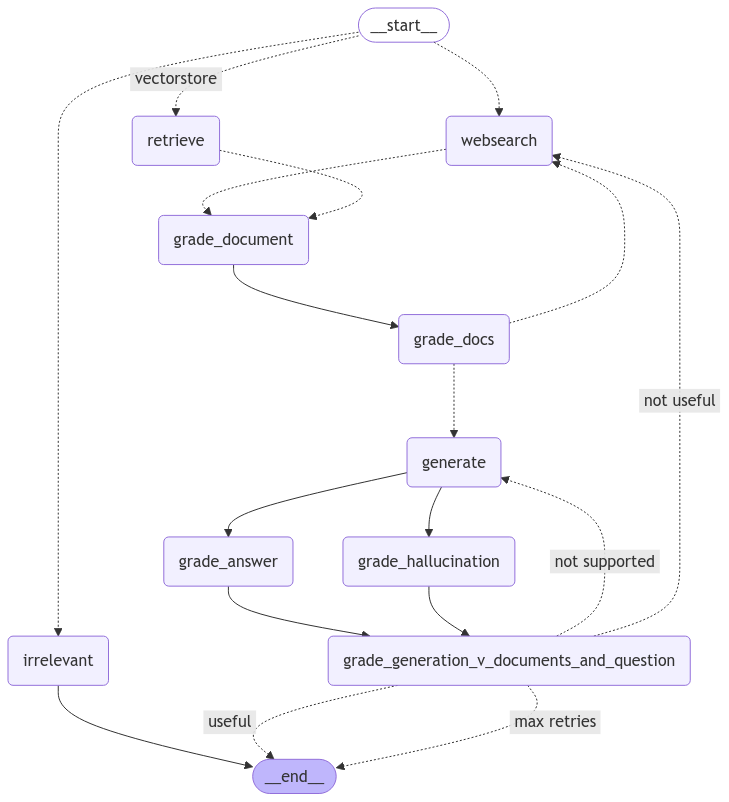

In [25]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("irrelevant", handle_irrelevant)  # handle irrelevant
workflow.add_node("grade_document", grade_document)  # grade document
workflow.add_node("grade_docs", grade_docs)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("grade_hallucination", grade_hallucination)  # grade hallucination
workflow.add_node("grade_answer", grade_answer)  # grade answer
workflow.add_node(
    "grade_generation_v_documents_and_question",
    grade_generation_v_documents_and_question,
)  # grade generation vs documents and question

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
        "irrelevant": "irrelevant",
    },
)
workflow.add_conditional_edges("websearch", continue_to_gradings, ["grade_document"])
workflow.add_conditional_edges("retrieve", continue_to_gradings, ["grade_document"])
workflow.add_edge("grade_document", "grade_docs")
workflow.add_conditional_edges(
    "grade_docs",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("generate", "grade_hallucination")
workflow.add_edge("generate", "grade_answer")
workflow.add_edge("grade_hallucination", "grade_generation_v_documents_and_question")
workflow.add_edge("grade_answer", "grade_generation_v_documents_and_question")
workflow.add_conditional_edges(
    "grade_generation_v_documents_and_question",
    lambda state: state["decision"],
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)
workflow.add_edge("irrelevant", END)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
inputs = {
    "question": "What are the models released today for llama3.2?",
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO IRRELEVANT---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0, 'filtered_docs': [], 'grades': [], 'generation_grades': []}
---HANDLE IRRELEVANT---
{'question': 'What are the models released today for llama3.2?', 'generation': 'This question is not related to the Rummikub rules. Please ask something specific about the game.', 'max_retries': 3, 'loop_step': 0, 'filtered_docs': [], 'grades': [], 'generation_grades': []}


In [27]:
inputs = {
    "question": "What is the purpose of the joker tile in Rummikub?",
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What is the purpose of the joker tile in Rummikub?', 'max_retries': 3, 'loop_step': 0, 'filtered_docs': [], 'grades': [], 'generation_grades': []}
---RETRIEVE---
{'question': 'What is the purpose of the joker tile in Rummikub?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'CreationDate': "D:20241118154334+01'00'", 'Creator': 'Adobe Acrobat Pro (32-bit) 24.4.20272', 'ModDate': "D:20241123190612+01'00'", 'Producer': 'Adobe Acrobat Pro (32-bit) 24.4.20272', 'Title': '2600-0236-0041 080719_rummikub rules', 'file_path': '../../data\\rummikub_rules.pdf', 'page': 3, 'source': '../../data\\rummikub_rules.pdf', 'total_pages': 13}, page_content='possible. In the early stages of the game it’s a good idea to hold back some tiles so that other players open\nup the table and provide more opportunities for play. Sometimes it is useful to hold back the fourth tile of\na group or run and play only three, so that on th

In [28]:
inputs = {"question": "Is there a Rummikub championship?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'Is there a Rummikub championship?', 'max_retries': 3, 'loop_step': 0, 'filtered_docs': [], 'grades': [], 'generation_grades': []}
---WEB SEARCH---
{'question': 'Is there a Rummikub championship?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Are There Rummikub Tournaments? Are There Rummikub Tournaments? 1 When was the first Rummikub tournament? 2 Rummikub tournaments 4 Rummikub Tournament Rules 6 The Joker in the Rummikub tournament So are there Rummikub tournaments? Rummikub is a professional game that has tournaments to see who is the best in the world every three years. When was the first Rummikub tournament? When the creator of the Rummikub game, Ephraim sadly passed away at the age of 75, it motivated his children to set in motion the first Rummikub Championship tournament. Rummikub tournaments Rummikub Tournament Rules The Joker in the Rummikub tournament If a joker is st

In [29]:
inputs = {
    "question": "What is the purpose of the joker tile in Rummikub?",
    "max_retries": 3,
}

# Execute the graph synchronously (no streaming)
final_state = graph.invoke(inputs)

print(final_state["generation"].content)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---CHECK IF WEB SEARCH IS NECESSARY---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---GRADE HALLUCINATION------GRADE GENERATION vs QUESTION---

---DECISION: GENERATION ADDRESSES QUESTION---
---DECISION: GENERATION GROUNDED IN DOCUMENT---
---CHECK GRADINGS---
---DECISION: GENERATION ADDRESSES QUESTION---
The joker tile in Rummikub serves as a wildcard, allowing players to substitute it for any specific tile when forming sets or runs. However, there are restrictions on using the joker, such as not being able to take tiles away from combinations containing a joker and not being able to rearrange them while they contain a joker.


## Conclusion
The parallelization of tasks in the RAG agent workflow significantly improves the efficiency and speed of generating answers. By executing tasks concurrently, the agent can process multiple operations simultaneously, reducing the overall processing time and enhancing decision-making capabilities.